In [23]:
!pip install pytorch-fid

# Question 1: Control VAE

* Dataset -  dSprites (2D shape)
* Models: VAE | Control VAE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files

import requests
import zipfile
import io

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
import torch.optim as optim
import torch


from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Lambda, Reshape, Flatten, LeakyReLU, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import cv2
import random
import click

## 1-1. Intro - load data

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(path_file, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

In [ ]:
for i in range(10):
    print(f"Image {i + 1} size: {imgs[i].shape}")

Image 1 size: (64, 64)
Image 2 size: (64, 64)
Image 3 size: (64, 64)
Image 4 size: (64, 64)
Image 5 size: (64, 64)
Image 6 size: (64, 64)
Image 7 size: (64, 64)
Image 8 size: (64, 64)
Image 9 size: (64, 64)
Image 10 size: (64, 64)


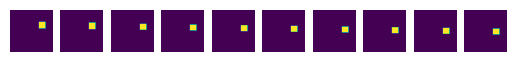

In [ ]:
import matplotlib.pyplot as plt


num_samples_to_display = 10

for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(imgs[i+1000])
    plt.axis('off')

plt.show()


## Dataloader

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

class DspritesDataset(Dataset):
    def __init__(self, imgs):
        self.data = imgs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.from_numpy(self.data[idx]).float()
        sample = sample.unsqueeze(0)
        return sample

def load_dsprites(file_name, path_file, batch_size=64, validation_split=0.2, shuffle_dataset=True, random_seed=42):
    # Load the dataset
    imgs = np.load(path_file, allow_pickle=True, encoding='latin1')['imgs']

    # Define the transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Create the dataset
    dataset = DspritesDataset(imgs)

    # Split the dataset into training and validation sets
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Create data loaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

# Example usage
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
train_loader, val_loader = load_dsprites(file_name, path_file, batch_size=64, validation_split=0.2)


In [ ]:
train_loader

In [ ]:
print("Image shape:", imgs[0].shape)

Image shape: (64, 64)


## VAE For Test

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

class VAE_Simple(nn.Module):
    def __init__(self, input_size=64*64, hidden_size=256, latent_size=10):
        super(VAE_Simple, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64*64))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64*64), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

model = VAE_Simple()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def accuracy(recon_x, x):
    # Use a threshold to determine predicted class
    predicted = recon_x.view(-1) > 0.5
    correct = (predicted == x.view(-1).byte()).float()
    acc = correct.sum() / x.numel()
    return acc.item()


# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    for data in train_loader:
        inputs = data.float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, logvar)
        acc = accuracy(recon_batch, inputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

    average_loss = total_loss / len(train_loader.dataset)
    average_acc = total_acc / len(train_loader.dataset)

    print(f'Train Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Acc: {average_acc:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs = data.float()
            recon_batch, mu, logvar = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, logvar)
            acc = accuracy(recon_batch, inputs)

            val_loss += loss.item()
            val_acc += acc

    average_val_loss = val_loss / len(val_loader.dataset)
    average_val_acc = val_acc / len(val_loader.dataset)

    print(f'Validation Epoch {epoch + 1}/{num_epochs}, Loss: {average_val_loss:.4f}, Acc: {average_val_acc:.4f}')


Train Epoch 1/2, Loss: 1053.4529, Acc: 0.0113
Validation Epoch 1/2, Loss: 157.5542, Acc: 0.0030
Train Epoch 2/2, Loss: 497.7572, Acc: 0.0120
Validation Epoch 2/2, Loss: 93.8927, Acc: 0.0030


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*8*8, 64)
        self.fc_logvar = nn.Linear(128*8*8, 64)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Instantiate the model and set up the optimizer
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
for epoch in range(2):  # Change the number of epochs as needed
    vae.train()
    for data in train_loader:
        inputs = data.float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = vae(inputs)

        # Compute the reconstruction loss and the KL divergence
        reconstruction_loss = F.binary_cross_entropy(recon_batch, inputs, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        print("Epoch {}, Loss: {:.4f}".format(epoch + 1, loss.item()))


Epoch 1, Loss: 200343.4844
Epoch 1, Loss: 187094.2344
Epoch 1, Loss: 161637.2344
Epoch 1, Loss: 111929.9141
Epoch 1, Loss: 248640.4375
Epoch 1, Loss: 86558.6094
Epoch 1, Loss: 74277.8281
Epoch 1, Loss: 77315.6328
Epoch 1, Loss: 75913.8672
Epoch 1, Loss: 72406.0391
Epoch 1, Loss: 65561.2969
Epoch 1, Loss: 59326.8242
Epoch 1, Loss: 58188.1836
Epoch 1, Loss: 50564.7227
Epoch 1, Loss: 57239.1797
Epoch 1, Loss: 58016.9258
Epoch 1, Loss: 59292.4570
Epoch 1, Loss: 55560.2305
Epoch 1, Loss: 52384.4922
Epoch 1, Loss: 51773.2383
Epoch 1, Loss: 49927.4961
Epoch 1, Loss: 47015.9727
Epoch 1, Loss: 52367.4609
Epoch 1, Loss: 46226.6172
Epoch 1, Loss: 47960.8438
Epoch 1, Loss: 45853.7656
Epoch 1, Loss: 40178.5938
Epoch 1, Loss: 38617.7422
Epoch 1, Loss: 40911.1875
Epoch 1, Loss: 38808.9922
Epoch 1, Loss: 42135.5156
Epoch 1, Loss: 43340.3281
Epoch 1, Loss: 38395.1719
Epoch 1, Loss: 40507.4883
Epoch 1, Loss: 40143.1719
Epoch 1, Loss: 42428.0625
Epoch 1, Loss: 45997.1875
Epoch 1, Loss: 41528.4766
Epoch 1

In [ ]:
for epoch in range(2):  # Change the number of epochs as needed
    model.train()
    for data in train_loader:
        inputs = data.float()
        print("Input shape: (barch | channel | height and width)", inputs.size())

Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64

## VAE Beta For Test

In [ ]:
'''
Loss Functions
'''

def kl_divergence_stdnorm(z_mean, z_log_sigma):

  kl = -0.5*K.mean(K.sum(1 + 2*z_log_sigma - K.square(z_mean) - K.exp(2*z_log_sigma), axis=1))
  return kl

def reconstruction_ll(x_true, x_prob_logit):

  x_true = K.batch_flatten(x_true)
  x_prob_logit = K.batch_flatten(x_prob_logit)

  ce = K.binary_crossentropy(x_true, x_prob_logit, from_logits=True)
  ce = K.sum(ce, axis=1)
  ce = K.mean(ce)

  return ce
def beta_vae_loss(x_true, z_mean, z_log_sigma, x_rec_logit, beta=4.0):

  reconstruction_l = reconstruction_ll(x_true, x_rec_logit)
  kl_divergence = kl_divergence_stdnorm(z_mean, z_log_sigma)

  beta_vae_l = reconstruction_l + beta*kl_divergence

  return beta_vae_l, reconstruction_l, kl_divergence


'''
Utility Functions
'''

def norm_sampling(mean, log_stdev):

  epsilon = K.random_normal(shape=K.shape(mean))

  return mean + K.exp(log_stdev) * epsilon

def permute_dims(z):

  shuffled_features = [K.expand_dims(tf.random.shuffle(z[:,i]), axis=-1) for i in range(K.int_shape(z)[1])]
  shuffled = K.concatenate(shuffled_features, axis=-1)

  return shuffled


In [ ]:
class Encoder(Model):

  def __init__(self, latent_dims):
    super(Encoder, self).__init__(name='encoder')

    self.latent_dims = latent_dims

    self.reshape_input = Reshape((64,64,1), input_shape=(64,64))
    self.hidden_layers = [Conv2D(32, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same') for _ in range(2)]
    self.hidden_layers += [Conv2D(64, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same') for _ in range(2)]
    self.hidden_layers += [Flatten(), Dense(128)]

    self.means = Dense(self.latent_dims)
    self.log_stdevs = Dense(self.latent_dims)

  def call(self, x):

    x = self.reshape_input(x)
    for h in self.hidden_layers:
      x = h(x)

    return self.means(x), self.log_stdevs(x)



class Decoder(Model):

  def __init__(self, latent_dims):
    super(Decoder, self).__init__(name='decoder')

    self.latent_dims = latent_dims

    self.hidden_layers = [
      Dense(128, activation='relu', input_shape=(self.latent_dims,)),
      Dense(4*4*64, activation='relu'),
      Reshape((4, 4, 64)),
      Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),
      Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),
      Conv2DTranspose(32, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),
      Conv2DTranspose(1, kernel_size=(4,4), strides=(2,2), padding='same'),
      Reshape((64, 64))
    ]

  def call(self, x):

    for h in self.hidden_layers:
      x = h(x)

    return x

In [ ]:
class BetaVAE():

  def __init__(self, latent_dims=10, beta=4.0):
    super(BetaVAE, self).__init__()

    self.beta = beta
    self.latent_dims = latent_dims

    self.encoder = Encoder(latent_dims)
    self.decoder = Decoder(latent_dims)

  def fit(self, X, batch_size=64):

    X_train, X_val = train_test_split(X, train_size=0.75, test_size=0.25, random_state=38, shuffle=True)

    X_train_ds = tf.data.Dataset.from_tensor_slices(X_train)
    X_train_ds = X_train_ds.shuffle(buffer_size=1024).batch(batch_size)

    beta_vae_optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)

    iterations_per_epoch = X_train.shape[0]/batch_size
    iterations = 3e5
    n_epochs = int(iterations/iterations_per_epoch)

    for epoch in range(0, n_epochs):
      print("Epoch %d/%d" % (epoch+1, n_epochs))

      bar = Progbar(X_train.shape[0], stateful_metrics=["val_loss"], verbose=1)

      last_step = int(np.ceil(X_train.shape[0]/batch_size)) - 1
      for step, x_batch in enumerate(X_train_ds):
        beta_vae_l, rec_l, kl_div = self._train_step(x_batch, beta_vae_optimizer)

        if step == last_step:
          val_beta_vae_l, val_rec_l, val_kl_div = self._evaluate(X_val)
          bar.add(x_batch.shape[0],
                  values=[
                    ("loss", beta_vae_l),
                    ("rec_loss", rec_l),
                    ("kl_div", kl_div),
                    ("val_loss", val_beta_vae_l),
                    ("val_rec_loss", val_rec_l),
                    ("val_kl_div", val_kl_div),
                  ])

        else:
          bar.add(x_batch.shape[0],
                  values=[
                    ("loss", beta_vae_l),
                    ("rec_loss", rec_l),
                    ("kl_div", kl_div),
                  ])

  @tf.function
  def _train_step(self, X, optimizer):

    with tf.GradientTape() as tape:

      z_mean, z_stdev = self.encoder(X)
      samples = norm_sampling(z_mean, z_stdev)
      z_rec = self.decoder(samples)

      beta_vae_l, rec_l, kl_div = beta_vae_loss(X, z_mean, z_stdev, z_rec, self.beta)

    # optimize VAE
    variables = self.encoder.trainable_variables + self.decoder.trainable_variables
    grad = tape.gradient(beta_vae_l, variables)

    optimizer.apply_gradients(zip(grad, variables))

    return beta_vae_l, rec_l, kl_div

  @tf.function
  def _evaluate(self, X):

    z_mean, z_stdev = self.encoder(X)
    samples = norm_sampling(z_mean, z_stdev)
    z_rec = self.decoder(samples)

    beta_vae_l, rec_l, kl_div = beta_vae_loss(X, z_mean, z_stdev, z_rec, self.beta)

    return beta_vae_l, rec_l, kl_div

##  Test VAE


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BetaVAE(nn.Module):
    def __init__(self, beta=1.0):
        super(BetaVAE, self).__init__()
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size=4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 20)  # 2 * 10 for mean and logvar
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Unflatten(1, (256, 2, 2)),
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu_logvar = self.encoder(x)
        mu, logvar = torch.split(mu_logvar, 10, dim=1)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)

        # Compute the reconstruction loss and the KL divergence with the beta factor
        reconstruction_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss with the beta factor
        loss = reconstruction_loss + self.beta * kl_divergence

        return x_recon, mu, logvar, loss

# Instantiate the model and set up the optimizer
beta_vae = BetaVAE(beta=1.0)
optimizer = optim.Adam(beta_vae.parameters(), lr=0.0001, betas=(0.90, 0.99))



Epoch 1, Total Loss: 11652.9082
Epoch 2, Total Loss: 3685.8186
Epoch 3, Total Loss: 2942.5139
Epoch 4, Total Loss: 3091.7812
Epoch 5, Total Loss: 2903.3125
Epoch 6, Total Loss: 2925.5828
Epoch 7, Total Loss: 2777.6873
Epoch 8, Total Loss: 2934.2576
Epoch 9, Total Loss: 2759.7893
Epoch 10, Total Loss: 2900.8345


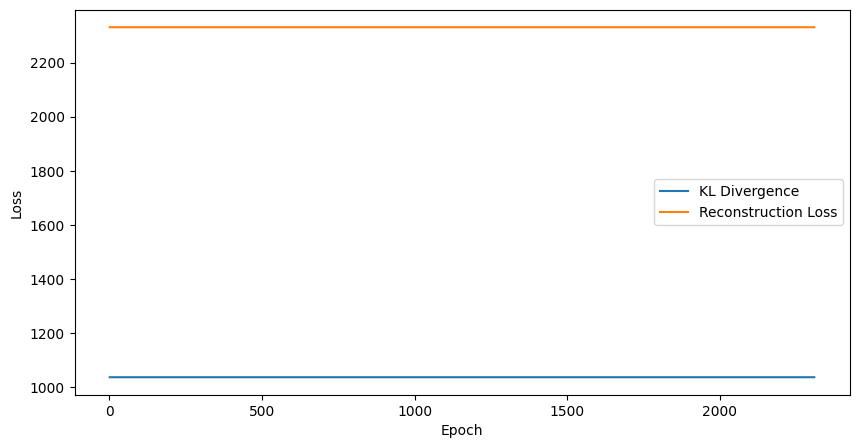

In [ ]:
kl_loss_list = []
recon_loss_list = []


for epoch in range(10):
    beta_vae.train()
    for data in train_loader:
        inputs = data.float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar, loss = beta_vae(inputs)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Store loss values
        kl_loss_list.append(kl_divergence.item())
        recon_loss_list.append(reconstruction_loss.item())

    print("Epoch {}, Total Loss: {:.4f}".format(epoch + 1, loss.item()))

# Plot KL divergence and reconstruction loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(kl_loss_list) + 1), kl_loss_list, label='KL Divergence')
plt.plot(range(1, len(recon_loss_list) + 1), recon_loss_list, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


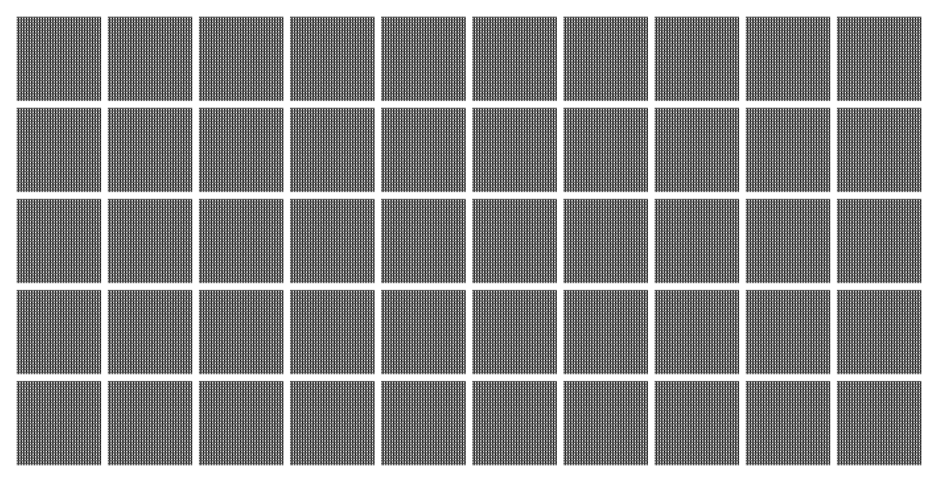

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

beta_vae.eval()

with torch.no_grad():
    random_samples = torch.randn(5 * 10, 10)  # 5 rows, 10 columns
    generated_images = beta_vae.decoder(random_samples).view(-1, 1, 64, 64)

plt.figure(figsize=(12, 6))
grid = vutils.make_grid(generated_images, nrow=10, normalize=True, padding=5, pad_value=1.0)
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()


## 1-2. Implementation VAE ( Beta )
## 1-3. Evaluation
* Optimizer  Adam
* with β1 = 0.90, β2 = 0.99
* Leaning rate 0.0001
* Reconstruction loss Bernoull

we compute loss KL and reconstruction over avg on each batch in training.

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(path_file, allow_pickle=True, encoding='latin1')
data = np.load(path_file, encoding='bytes')
data = torch.from_numpy(data['imgs']).unsqueeze(1).float()
imgs = imgs['imgs']

In [4]:
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=1,
                              pin_memory=False,
                              drop_last=True)
train_loader

In [5]:
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn.functional as F

def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            View((-1, 256, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1),  # B, nc, 64, 64
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)


def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()




In [18]:
beta_vae_h = BetaVAE_H(z_dim=10, nc=1)
optimizer = optim.Adam(beta_vae_h.parameters(), lr=0.0001, betas=(0.90, 0.99))

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

for epoch in range(10):
    beta_vae_h.train()

    total_loss = 0.0
    total_batches = 0

    for data in train_loader:
        inputs = data

        optimizer.zero_grad()

        recon_batch, mu, logvar = beta_vae_h(inputs)

        recon_batch_sigmoid = torch.sigmoid(recon_batch)

        reconstruction_loss = F.binary_cross_entropy_with_logits(recon_batch, inputs, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # avg
        batch_size = inputs.size(0)
        reconstruction_loss /= batch_size
        kl_divergence /= batch_size

        loss = reconstruction_loss + kl_divergence

        torch.nn.utils.clip_grad_norm_(beta_vae_h.parameters(), max_norm=5.0)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    average_loss = total_loss / total_batches
    print("Epoch {}, Average Loss: {:.4f}".format(epoch + 1, average_loss))


<ipython-input-5-7fbe6c9a8afc>:81: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


Epoch 1, Average Loss: 586.4060
Epoch 2, Average Loss: 126.2885
Epoch 3, Average Loss: 101.4562
Epoch 4, Average Loss: 90.5335
Epoch 5, Average Loss: 83.3371
Epoch 6, Average Loss: 78.2503
Epoch 7, Average Loss: 74.1549
Epoch 8, Average Loss: 71.0528
Epoch 9, Average Loss: 68.1310
Epoch 10, Average Loss: 66.1077


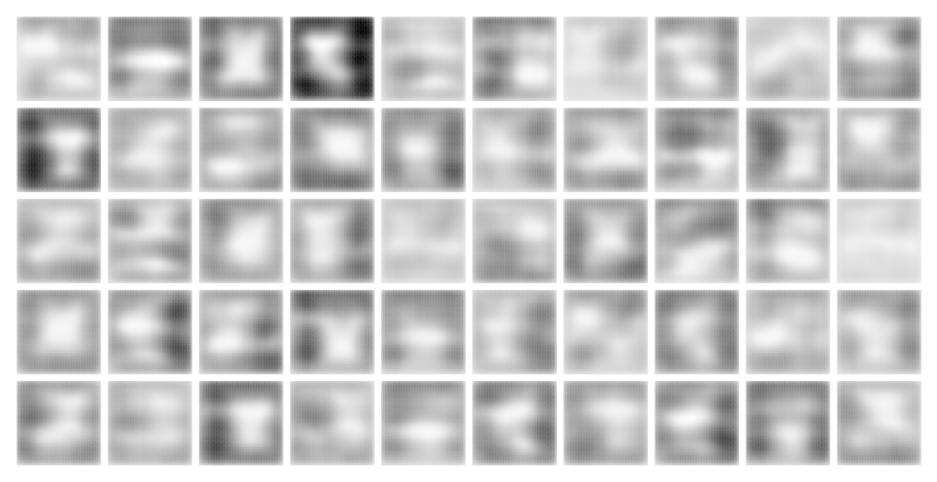

In [19]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

beta_vae_h.eval()

with torch.no_grad():
    random_samples = torch.randn(5 * 10, 10)  # 5 rows, 10 columns
    generated_images = beta_vae_h.decoder(random_samples).view(-1, 1, 64, 64)

plt.figure(figsize=(12, 6))
grid = vutils.make_grid(generated_images, nrow=10, normalize=True, padding=5, pad_value=1.0)
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()


The above images are computed with Reconstruction loss Bernoulli, binary_cross_entropy_with_logits.

However in as covered below if we use reconstruction_loss = F.mse_loss(recon_batch, inputs, reduction='sum')
instead we get better results


In [20]:
beta_vae_h = BetaVAE_H(z_dim=10, nc=1)
optimizer = optim.Adam(beta_vae_h.parameters(), lr=0.0001, betas=(0.90, 0.99))

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

for epoch in range(10):
    beta_vae_h.train()

    total_loss = 0.0
    total_batches = 0

    for data in train_loader:
        inputs = data

        optimizer.zero_grad()

        recon_batch, mu, logvar = beta_vae_h(inputs)

        recon_batch_sigmoid = torch.sigmoid(recon_batch)

        reconstruction_loss = F.mse_loss(recon_batch, inputs, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # avg
        batch_size = inputs.size(0)
        reconstruction_loss /= batch_size
        kl_divergence /= batch_size

        loss = reconstruction_loss + kl_divergence

        torch.nn.utils.clip_grad_norm_(beta_vae_h.parameters(), max_norm=5.0)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    average_loss = total_loss / total_batches
    print("Epoch {}, Average Loss: {:.4f}".format(epoch + 1, average_loss))


<ipython-input-5-7fbe6c9a8afc>:81: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


Epoch 1, Average Loss: 128.9862
Epoch 2, Average Loss: 57.7656
Epoch 3, Average Loss: 48.7405
Epoch 4, Average Loss: 43.5402
Epoch 5, Average Loss: 40.2721
Epoch 6, Average Loss: 38.3631
Epoch 7, Average Loss: 37.1307
Epoch 8, Average Loss: 36.2391
Epoch 9, Average Loss: 35.3984
Epoch 10, Average Loss: 34.8557


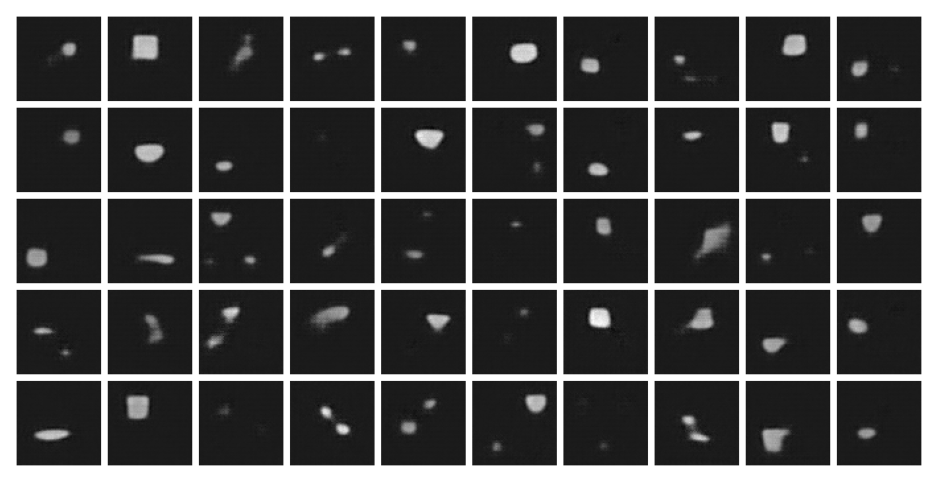

In [21]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

beta_vae_h.eval()

with torch.no_grad():
    random_samples = torch.randn(5 * 10, 10)  # 5 rows, 10 columns
    generated_images = beta_vae_h.decoder(random_samples).view(-1, 1, 64, 64)

plt.figure(figsize=(12, 6))
grid = vutils.make_grid(generated_images, nrow=10, normalize=True, padding=5, pad_value=1.0)
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()


### FID:
FID (Fréchet Inception Distance) is a metric used to evaluate the quality of generated images in comparison to a real dataset. It measures the similarity between two datasets in terms of the statistics of feature vectors extracted from a pre-trained neural network, typically an Inception model. Lower FID scores indicate better similarity between the generated and real datasets.

In [24]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import DatasetFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_fid import fid_score

In [25]:
beta_vae_h.eval()

BetaVAE_H(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): View()
    (11): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): View()
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(64, 32, kernel_siz

In [26]:
generated_images = []
num_samples = 500
with torch.no_grad():
    for _ in range(num_samples // 32):
        random_samples = torch.randn(batch_size, 10)
        generated_batch = beta_vae_h.decoder(random_samples).view(-1, 1, 64, 64)
        generated_images.append(generated_batch)

In [27]:
generated_images = torch.cat(generated_images, dim=0)

In [30]:
fid_value = fid_score.calculate_fid_given_paths([train_loader, generated_images], batch_size=batch_size)

TypeError: calculate_fid_given_paths() missing 2 required positional arguments: 'device' and 'dims'